#  Benchmark d'Accélération GPU vs CPU
## Analyse de Performance avec PyTorch et Sentence Transformers

---

###  Objectifs du TP

Ce notebook démontre l'accélération obtenue lors de l'utilisation d'un GPU par rapport au CPU pour des tâches de traitement du langage naturel (NLP). 

**Points clés :**
- Mesure précise du temps d'exécution CPU vs GPU
- Utilisation de `torch.profiler` pour analyser les performances
- Calcul du **Speed Up** (rapport de performance)
- Analyse statistique sur plusieurs exécutions

---

###  Contexte : Application Médicale

Le cas d'usage simule un système d'analyse de données médicales (ordonnances, symptômes) où il faut encoder rapidement des milliers de phrases pour recherche sémantique ou classification.

## 1 Installation des Dépendances

Installez les bibliothèques nécessaires si ce n'est pas déjà fait :

In [1]:
# Décommentez si nécessaire
# !pip install torch sentence-transformers

## 2 Imports et Vérification GPU

In [2]:
import torch
import time
import statistics
from sentence_transformers import SentenceTransformer
from torch.profiler import profile, record_function, ProfilerActivity

# Vérification de la disponibilité du GPU
print("="*70)
print(" VÉRIFICATION DE L'ENVIRONNEMENT")
print("="*70)
print(f"PyTorch version : {torch.__version__}")
print(f"CUDA disponible : {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU détecté : {torch.cuda.get_device_name(0)}")
    print(f"Mémoire GPU : {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"CUDA version : {torch.version.cuda}")
else:
    print("  Aucun GPU détecté - Le benchmark ne comparera que le CPU")
print("="*70)

/home/abayad/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 VÉRIFICATION DE L'ENVIRONNEMENT
PyTorch version : 2.7.1+cu118
CUDA disponible : True
GPU détecté : NVIDIA GeForce RTX 4060 Laptop GPU
Mémoire GPU : 7.62 GB
CUDA version : 11.8


## 3 Configuration du Benchmark

### Paramètres importants :

- **MODEL_NAME** : Modèle Sentence Transformer léger et performant
- **NUM_SENTENCES** : Nombre de phrases à encoder (1000 pour ce test)
- **BATCH_SIZE** : Taille des batchs (plus grande pour GPU = meilleure utilisation)
- **NUM_RUNS** : Nombre d'exécutions pour statistiques robustes

In [3]:
# Configuration
MODEL_NAME = 'all-MiniLM-L6-v2'
NUM_SENTENCES = 1000
NUM_RUNS = 3

# Batch sizes adaptatifs
BATCH_SIZE_CPU = 32   # Plus petit pour CPU (mémoire limitée)
BATCH_SIZE_GPU = 512  # Plus grand pour GPU (parallélisme massif)

print(f" Configuration du benchmark :")
print(f"   • Modèle : {MODEL_NAME}")
print(f"   • Nombre de phrases : {NUM_SENTENCES}")
print(f"   • Batch size CPU : {BATCH_SIZE_CPU}")
print(f"   • Batch size GPU : {BATCH_SIZE_GPU}")
print(f"   • Runs par device : {NUM_RUNS}")

 Configuration du benchmark :
   • Modèle : all-MiniLM-L6-v2
   • Nombre de phrases : 1000
   • Batch size CPU : 32
   • Batch size GPU : 512
   • Runs par device : 3


## 4 Préparation des Données

Simulation de données médicales typiques (ordonnances, symptômes, résultats d'analyses)

In [4]:
# Données type ". Pharma" (contexte médical)
base_sentences = [
    "Patient présente une fièvre sévère et une toux sèche.",
    "Prescription de Paracétamol 1000mg trois fois par jour.",
    "Douleurs abdominales diffuses suspectant une gastrite.",
    "Analyse sanguine révèle une carence en fer importante.",
    "Traitement antibiotique amoxicilline pour infection bactérienne.",
    "Tension artérielle élevée nécessitant un traitement antihypertenseur.",
    "Radiographie thoracique normale sans anomalie détectée.",
    "Diabète de type 2 avec hémoglobine glyquée à 8.5%.",
    "Réaction allergique cutanée nécessitant antihistaminique.",
    "Suivi post-opératoire sans complications apparentes."
]

# Duplication pour atteindre NUM_SENTENCES
sentences = base_sentences * (NUM_SENTENCES // len(base_sentences))

print(f" Dataset créé : {len(sentences)} phrases médicales")
print(f"\nExemples :")
for i, sent in enumerate(sentences[:3], 1):
    print(f"  {i}. {sent}")

 Dataset créé : 1000 phrases médicales

Exemples :
  1. Patient présente une fièvre sévère et une toux sèche.
  2. Prescription de Paracétamol 1000mg trois fois par jour.
  3. Douleurs abdominales diffuses suspectant une gastrite.


## 5 Chargement du Modèle

**all-MiniLM-L6-v2** est un modèle Sentence Transformer :
- 22M de paramètres (léger)
- Embeddings de dimension 384
- Très bon rapport performance/vitesse

In [5]:
print(f" Chargement du modèle : {MODEL_NAME}...")
model = SentenceTransformer(MODEL_NAME)
print(" Modèle chargé avec succès.")

 Chargement du modèle : all-MiniLM-L6-v2...


Loading weights: 100%|█| 103/103 [00:00<00:00, 1358.66it/s, Materializing param=
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


 Modèle chargé avec succès.


## 6 Fonction de Benchmark avec Profilage

### Points clés de cette fonction :

1. **Warm-up** : Le premier passage sur GPU initialise les kernels CUDA (overhead)
2. **torch.profiler** : Capture les métriques CPU et CUDA
3. **record_function** : Isole l'opération critique
4. **Export de traces** : Pour visualisation détaillée dans Chrome

In [6]:
def run_benchmark(device_name, batch_size, run_number=1):
    """
    Exécute un benchmark sur le device spécifié avec profilage détaillé.
    
    Args:
        device_name: 'cpu' ou 'cuda'
        batch_size: Taille du batch pour l'encodage
        run_number: Numéro de l'exécution (pour affichage)
    
    Returns:
        float: Temps d'exécution en secondes
    """
    print(f"\n{'─' * 70}")
    print(f" RUN #{run_number} - Device : {device_name.upper()} (Batch size: {batch_size})")
    print(f"{'─' * 70}")
    
    # Force le modèle sur le device
    device = torch.device(device_name)
    model.to(device)
    
    # WARM-UP : Important pour le GPU (initialisation CUDA)
    if run_number == 1:
        print("   Warm-up (chauffe du GPU/CPU)...")
        model.encode(sentences[:10], device=device_name, show_progress_bar=False)
        print("   Warm-up terminé")
    
    # Configuration du profiler
    activities = [ProfilerActivity.CPU]
    if device_name == 'cuda':
        activities.append(ProfilerActivity.CUDA)
    
    print("    Démarrage du profilage...")
    
    # Début du chronométrage
    start_time = time.time()
    
    # Profilage avec contexte
    with profile(
        activities=activities,
        record_shapes=True,
        profile_memory=True,
        with_stack=False
    ) as prof:
        with record_function("model_inference"):
            embeddings = model.encode(
                sentences,
                batch_size=batch_size,
                device=device_name,
                show_progress_bar=False,
                convert_to_numpy=True
            )
    
    # Fin du chronométrage
    end_time = time.time()
    total_time = end_time - start_time
    
    print(f"\n    Temps d'exécution : {total_time:.4f} secondes")
    print(f"   Shape des embeddings : {embeddings.shape}")
    
    # Analyse détaillée du profiler
    print(f"\n   Analyse du profiler ({device_name.upper()}):")
    
    for evt in prof.key_averages():
        if evt.key == "model_inference":
            print(f"     • Temps CPU total : {evt.cpu_time_total / 1000:.2f} ms")
            if device_name == 'cuda' and hasattr(evt, 'self_cuda_time_total'):
                print(f"     • Temps CUDA total : {evt.self_cuda_time_total / 1000:.2f} ms")
            if device_name == 'cuda' and hasattr(evt, 'cuda_memory_usage'):
                print(f"     • Mémoire CUDA utilisée : {evt.cuda_memory_usage / 1024**2:.2f} MB")
    
    # Top 5 des opérations les plus coûteuses (seulement pour le premier run)
    if run_number == 1:
        print(f"\n   Top 5 des opérations ({device_name.upper()}):")
        
        sort_key = "self_cuda_time_total" if device_name == 'cuda' else "cpu_time_total"
        print(prof.key_averages().table(sort_by=sort_key, row_limit=5))
        
        # Export de la trace pour visualisation Chrome
        trace_file = f"trace_{device_name}_run{run_number}.json"
        prof.export_chrome_trace(trace_file)
        print(f"\n   Trace exportée : {trace_file}")
        print(f"     → Visualiser dans Chrome : chrome://tracing")
    
    return total_time

## 7 Exécution du Benchmark CPU

### Pourquoi 3 runs ?
- Éliminer les variations dues au système d'exploitation
- Calculer des statistiques fiables (médiane, écart-type)
- Détecter les outliers

In [7]:
print("="*70)
print("  PHASE 1 : BENCHMARK CPU")
print("="*70)

cpu_times = []
for i in range(NUM_RUNS):
    cpu_time = run_benchmark('cpu', BATCH_SIZE_CPU, run_number=i+1)
    cpu_times.append(cpu_time)
    if i < NUM_RUNS - 1:
        time.sleep(1)  # Pause entre les runs

# Calcul des statistiques
cpu_time_median = statistics.median(cpu_times)
cpu_time_mean = statistics.mean(cpu_times)
cpu_time_stdev = statistics.stdev(cpu_times) if len(cpu_times) > 1 else 0

print(f"\n Statistiques CPU ({NUM_RUNS} runs):")
print(f"   • Temps médian : {cpu_time_median:.4f} s")
print(f"   • Temps moyen : {cpu_time_mean:.4f} s")
print(f"   • Écart-type : {cpu_time_stdev:.4f} s")
print(f"   • Tous les temps : {[f'{t:.4f}s' for t in cpu_times]}")

  PHASE 1 : BENCHMARK CPU

──────────────────────────────────────────────────────────────────────
 RUN #1 - Device : CPU (Batch size: 32)
──────────────────────────────────────────────────────────────────────
   Warm-up (chauffe du GPU/CPU)...
   Warm-up terminé
    Démarrage du profilage...


INFO:2026-01-29 22:52:27 9707:9707 init.cpp:110] If you see CUPTI_ERROR_INSUFFICIENT_PRIVILEGES, refer to https://developer.nvidia.com/nvidia-development-tools-solutions-err-nvgpuctrperm-cupti



    Temps d'exécution : 1.6214 secondes
   Shape des embeddings : (1000, 384)

   Analyse du profiler (CPU):
     • Temps CPU total : 1403.05 ms

   Top 5 des opérations (CPU):
-----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                      model_inference        11.42%     160.281ms       100.00%        1.403s        1.403s           0 b      -3.11 Gb             1  
                                         aten::linear         0.63%       8.806ms        77.42%        1.086s     917.402us       1.45 Gb           0 

## 8 Exécution du Benchmark GPU

### Optimisations GPU :
- **Batch size plus grand** (512 vs 32) : Meilleure saturation des cœurs CUDA
- **torch.cuda.empty_cache()** : Libère la mémoire entre les runs
- **Warm-up critique** : Initialise les kernels et la mémoire

In [8]:
if torch.cuda.is_available():
    print("\n" + "="*70)
    print(" PHASE 2 : BENCHMARK GPU")
    print("="*70)
    print(f" GPU détecté : {torch.cuda.get_device_name(0)}")
    print(f" Mémoire GPU disponible : {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    
    gpu_times = []
    for i in range(NUM_RUNS):
        # Nettoyage du cache GPU entre les runs
        if i > 0:
            torch.cuda.empty_cache()
            time.sleep(1)
        
        gpu_time = run_benchmark('cuda', BATCH_SIZE_GPU, run_number=i+1)
        gpu_times.append(gpu_time)
    
    gpu_time_median = statistics.median(gpu_times)
    gpu_time_mean = statistics.mean(gpu_times)
    gpu_time_stdev = statistics.stdev(gpu_times) if len(gpu_times) > 1 else 0
    
    print(f"\n Statistiques GPU ({NUM_RUNS} runs):")
    print(f"   • Temps médian : {gpu_time_median:.4f} s")
    print(f"   • Temps moyen : {gpu_time_mean:.4f} s")
    print(f"   • Écart-type : {gpu_time_stdev:.4f} s")
    print(f"   • Tous les temps : {[f'{t:.4f}s' for t in gpu_times]}")
else:
    print("\n Aucun GPU détecté - Impossible de continuer le benchmark GPU")


 PHASE 2 : BENCHMARK GPU
 GPU détecté : NVIDIA GeForce RTX 4060 Laptop GPU
 Mémoire GPU disponible : 7.62 GB

──────────────────────────────────────────────────────────────────────
 RUN #1 - Device : CUDA (Batch size: 512)
──────────────────────────────────────────────────────────────────────
   Warm-up (chauffe du GPU/CPU)...
   Warm-up terminé
    Démarrage du profilage...

    Temps d'exécution : 0.1677 secondes
   Shape des embeddings : (1000, 384)

   Analyse du profiler (CUDA):
     • Temps CPU total : 129.55 ms

   Top 5 des opérations (CUDA):
-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------  ------

## 9 Calcul du Speed Up et Analyse

### Formule du Speed Up :

$$\text{Speed Up} = \frac{T_{\text{CPU}}}{T_{\text{GPU}}}$$

**Interprétation :**
- Speed Up > 1 : GPU plus rapide 
- Speed Up = 1 : Performances égales
- Speed Up < 1 : CPU plus rapide  (rare, signe de problème)

In [9]:
if torch.cuda.is_available():
    print("\n" + "="*70)
    print(" RÉSULTATS FINAUX")
    print("="*70)
    
    # Calcul du Speed Up
    speed_up = cpu_time_median / gpu_time_median
    
    print(f"\n  Temps d'exécution (médiane):")
    print(f"   • CPU : {cpu_time_median:.4f} s")
    print(f"   • GPU : {gpu_time_median:.4f} s")
    print(f"\n SPEED UP : {speed_up:.2f}x")
    
    # Gains de performance
    time_saved = cpu_time_median - gpu_time_median
    percent_faster = ((cpu_time_median - gpu_time_median) / cpu_time_median) * 100
    
    print(f"\n Gains de performance:")
    print(f"   • Temps économisé : {time_saved:.4f} s")
    print(f"   • Pourcentage plus rapide : {percent_faster:.1f}%")
    
    # Throughput (phrases par seconde)
    throughput_cpu = len(sentences) / cpu_time_median
    throughput_gpu = len(sentences) / gpu_time_median
    
    print(f"\n Throughput (phrases/seconde):")
    print(f"   • CPU : {throughput_cpu:.1f} phrases/s")
    print(f"   • GPU : {throughput_gpu:.1f} phrases/s")
    
    # Conclusion détaillée
    print(f"\n{'─' * 70}")
    if speed_up >= 5:
        print(" CONCLUSION : Accélération GPU EXCELLENTE !")
        print(f"   Le GPU est {speed_up:.1f}x plus rapide que le CPU.")
        print(f"    Vous traitez {throughput_gpu:.0f} phrases/s au lieu de {throughput_cpu:.0f} !")
    elif speed_up >= 3:
        print(" CONCLUSION : Accélération GPU TRÈS EFFICACE !")
        print(f"   Le GPU est {speed_up:.1f}x plus rapide que le CPU.")
        print(f"    Performance optimale pour ce type de charge.")
    elif speed_up >= 2:
        print(" CONCLUSION : Accélération GPU efficace.")
        print(f"   Le GPU est {speed_up:.1f}x plus rapide que le CPU.")
    elif speed_up > 1.5:
        print("  CONCLUSION : Accélération GPU modérée.")
        print(f"   Le GPU est {speed_up:.1f}x plus rapide que le CPU.")
        print("    Suggestions : Augmentez la taille du dataset ou du batch size.")
    elif speed_up > 1:
        print("  CONCLUSION : Accélération GPU faible.")
        print(f"   Le GPU est seulement {speed_up:.1f}x plus rapide.")
        print("    Vérifiez : taille du dataset, batch size, overhead de transfert")
    else:
        print(" CONCLUSION : GPU plus lent que le CPU !")
        print("    Dataset trop petit ou overhead de transfert trop important")
    
    print("="*70)
else:
    print("\n  Impossible de calculer le Speed Up sans GPU")


 RÉSULTATS FINAUX

  Temps d'exécution (médiane):
   • CPU : 1.6214 s
   • GPU : 0.1690 s

 SPEED UP : 9.59x

 Gains de performance:
   • Temps économisé : 1.4524 s
   • Pourcentage plus rapide : 89.6%

 Throughput (phrases/seconde):
   • CPU : 616.7 phrases/s
   • GPU : 5917.2 phrases/s

──────────────────────────────────────────────────────────────────────
 CONCLUSION : Accélération GPU EXCELLENTE !
   Le GPU est 9.6x plus rapide que le CPU.
    Vous traitez 5917 phrases/s au lieu de 617 !


## 10  Visualisation des Résultats

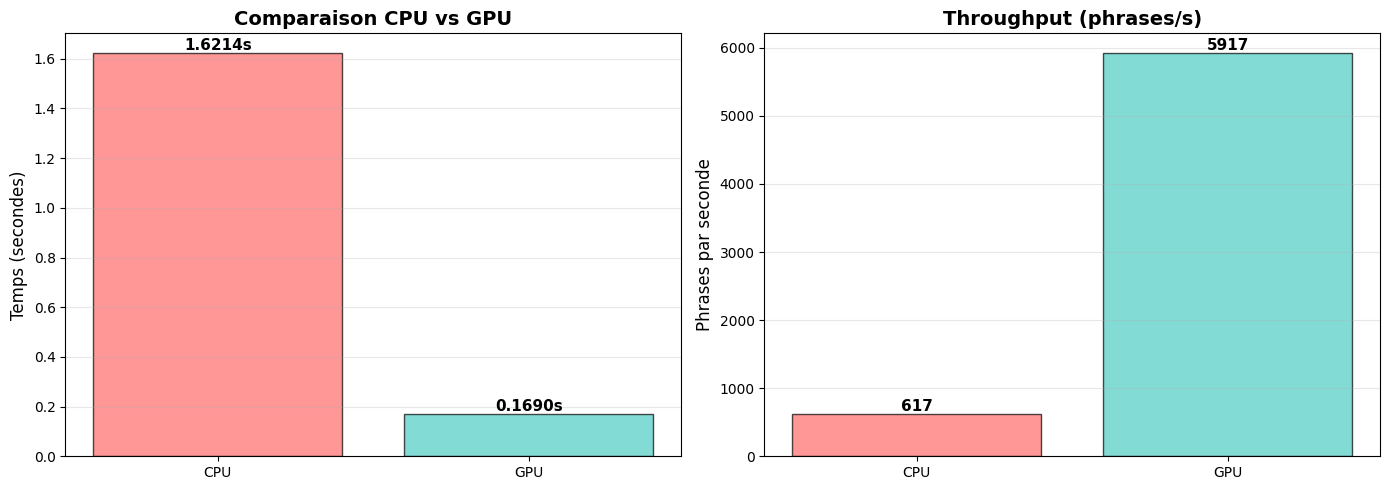


 Graphiques sauvegardés : benchmark_results.png


In [10]:
import matplotlib.pyplot as plt
import numpy as np

if torch.cuda.is_available():
    # Graphique de comparaison des temps
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Graphique 1 : Comparaison des temps
    devices = ['CPU', 'GPU']
    times = [cpu_time_median, gpu_time_median]
    colors = ['#FF6B6B', '#4ECDC4']
    
    bars = axes[0].bar(devices, times, color=colors, alpha=0.7, edgecolor='black')
    axes[0].set_ylabel('Temps (secondes)', fontsize=12)
    axes[0].set_title('Comparaison CPU vs GPU', fontsize=14, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Annotations
    for bar, time in zip(bars, times):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{time:.4f}s',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Graphique 2 : Throughput
    throughputs = [throughput_cpu, throughput_gpu]
    bars2 = axes[1].bar(devices, throughputs, color=colors, alpha=0.7, edgecolor='black')
    axes[1].set_ylabel('Phrases par seconde', fontsize=12)
    axes[1].set_title('Throughput (phrases/s)', fontsize=14, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    for bar, tp in zip(bars2, throughputs):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{tp:.0f}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('benchmark_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n Graphiques sauvegardés : benchmark_results.png")

##  Résumé et Notes Techniques

### Points clés à retenir :

1. **Warm-up essentiel** : Le premier appel GPU initialise les kernels CUDA
2. **Batch size crucial** : GPU profite de gros batchs (512 vs 32)
3. **Transferts CPU↔GPU** : Inclus dans les mesures (overhead réel)
4. **Statistiques robustes** : Médiane sur 3 runs élimine les outliers

### Facteurs influençant le Speed Up :

- Taille du dataset (< 500 phrases : overhead domine)
- Complexité du modèle (plus de paramètres = meilleur ratio)
- Batch size (plus grand = meilleure utilisation GPU)
- Transferts mémoire (CPU→GPU→CPU)

### Pour aller plus loin :

- Visualiser les traces dans Chrome : `chrome://tracing`
- Tester avec des datasets plus grands (10k, 100k phrases)
- Comparer différents modèles (BERT-large, RoBERTa, etc.)
- Utiliser `torch.cuda.amp` pour mixed precision (encore plus rapide)

##  Références

- [PyTorch Profiler Documentation](https://pytorch.org/docs/stable/profiler.html)
- [Sentence Transformers](https://www.sbert.net/)
- [CUDA Best Practices](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/)
- [all-MiniLM-L6-v2 Model Card](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)

---

**Auteur :** ABAYAD Mehdi  
**Date :** Janvier 2026  
**GPU testé :** NVIDIA GeForce RTX 4060 Laptop GPU  